In [46]:
# imports
import sys
sys.path.insert(1, 'C:/Users/jo77pihe/Documents/MasterThesis_OfSpinesAndDendrites')
from imagequalitymetrics import ImageQualityMetrics
#import SIREN
import matplotlib.pyplot as plt
import numpy as np
import imageio as io
#import tensorflow as tf
import os
from numpy.random import default_rng
import normalize
import tifffile as tif
from nutil.plot import paperStyle
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from nutil.plot import paperStyle

In [2]:
data_path = 'D:/jo77pihe/Registered/20220203_AutoQuant_Averaged'

In [3]:
# Randomly select 15 images
f = [f for f in os.listdir(data_path) if f.endswith('.tif')]

rng = default_rng(1234)
idx = rng.choice(len(f), size=15, replace=False)
idx_preproc =idx[0:5]
idx_train = idx[5:]
f_train = [f[i] for i in idx_train]
f_preproc = [f[i] for i in idx_preproc]
print(idx)
print(f_preproc)
print(f_train)

[222 227  32  61  24  75 189 127  87 214 226  58 190  28  39]
['Tim_2_NexCreERT2_2018-07-17_A2.tif', 'Tim_38_NexCreERT2_2018-08-22_D4.tif', 'Alessandro_520_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-08-31_A2.tif', 'Ghabiba_341_Thy1GFP_2019-02-18_A1.tif', 'Alessandro_516_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-08-31_A1.tif']
['Ghabiba_347_Thy1GFP_2019-02-18_A5.tif', 'Tim_178_ArcCre_2017-08-08_A2.tif', 'Tim_117_ArcCre_2017-05-08_A9.tif', 'Ghabiba_65_Thy1eGFP_2018-02-03_A1.tif', 'Tim_25_NexCreERT2_2018-07-10_A7.tif', 'Tim_38_NexCreERT2_2018-08-22_D3.tif', 'Ghabiba_335_Thy1GFP_2019-02-18_A5.tif', 'Tim_178_ArcCre_2017-08-08_A3.tif', 'Alessandro_516_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-08-31_A5.tif', 'Alessandro_530_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-09-16_A2.tif']


## 0 Network architecture
*Which network architecture is suitable for representing our image stack sufficiently precise?*
* Perform grid search

In [7]:
met = ImageQualityMetrics()
normalizer = normalize.PercentileNormalizer()

In [ ]:
import time
p = 'D:/jo77pihe/Registered/Repetitions'
img = 'Tim_2_NexCreERT2_2018-07-17_A1'
i=0
f = 128
h = 1
args={}
args['hidden_layers'] = h
args['hidden_features']=f
plane_int = SIREN.application.Motion_Correction(args)
print(plane_int.model.model.summary())

stack = np.asarray(io.mimread(os.path.join(data_path, f_preproc[i])), dtype=np.float32)
gt, bz = plane_int.preprocess(p, img)
plane_int.train(gt,n_steps=steps, steps_to_plot=step_to_plot, batch_size=bz)
prediction = plane_int.test(gt)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               512       
_________________________________________________________________
tf.math.multiply_4 (TFOpLamb (None, 128)               0         
_________________________________________________________________
tf.math.sin_4 (TFOpLambda)   (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
tf.math.multiply_5 (TFOpLamb (None, 128)               0         
_________________________________________________________________
tf.math.sin_5 (TFOpLambda)   (None, 128)               0   

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step - loss: 0.0626


  0%|                                                                                 | 1/1000 [00:02<39:17,  2.36s/it]

1/1 [==============================] - 1s 517ms/step - loss: 0.6412


  0%|▏                                                                                | 2/1000 [00:03<26:58,  1.62s/it]

1/1 [==============================] - 1s 504ms/step - loss: 0.1517


  0%|▏                                                                                | 3/1000 [00:04<22:45,  1.37s/it]

1/1 [==============================] - 1s 518ms/step - loss: 0.0735


  0%|▎                                                                                | 4/1000 [00:05<20:51,  1.26s/it]

1/1 [==============================] - 0s 479ms/step - loss: 0.0696


  0%|▍                                                                                | 5/1000 [00:06<19:19,  1.17s/it]

1/1 [==============================] - 1s 503ms/step - loss: 0.0656


  1%|▍                                                                                | 6/1000 [00:07<18:36,  1.12s/it]

1/1 [==============================] - 0s 433ms/step - loss: 0.0592


  1%|▌                                                                                | 7/1000 [00:08<18:11,  1.10s/it]

1/1 [==============================] - 0s 486ms/step - loss: 0.0500


  1%|▋                                                                                | 8/1000 [00:09<18:06,  1.10s/it]

1/1 [==============================] - 1s 522ms/step - loss: 0.0443


  1%|▋                                                                                | 9/1000 [00:10<17:55,  1.08s/it]

1/1 [==============================] - 0s 499ms/step - loss: 0.0418


  1%|▊                                                                               | 10/1000 [00:11<17:33,  1.06s/it]

1/1 [==============================] - 1s 533ms/step - loss: 0.0394


  1%|▉                                                                               | 11/1000 [00:12<17:18,  1.05s/it]

1/1 [==============================] - 0s 471ms/step - loss: 0.0359


  1%|▉                                                                               | 12/1000 [00:13<17:03,  1.04s/it]

1/1 [==============================] - 1s 502ms/step - loss: 0.0321


  1%|█                                                                               | 13/1000 [00:14<17:18,  1.05s/it]

1/1 [==============================] - 0s 432ms/step - loss: 0.0289


  1%|█                                                                               | 14/1000 [00:16<17:07,  1.04s/it]

1/1 [==============================] - 0s 479ms/step - loss: 0.0266


  2%|█▏                                                                              | 15/1000 [00:17<17:14,  1.05s/it]

1/1 [==============================] - 1s 508ms/step - loss: 0.0248


  2%|█▎                                                                              | 16/1000 [00:18<17:18,  1.06s/it]

1/1 [==============================] - 1s 501ms/step - loss: 0.0231


  2%|█▎                                                                              | 17/1000 [00:19<17:15,  1.05s/it]

1/1 [==============================] - 1s 523ms/step - loss: 0.0214


  2%|█▍                                                                              | 18/1000 [00:20<17:15,  1.05s/it]

1/1 [==============================] - 0s 485ms/step - loss: 0.0198


  2%|█▌                                                                              | 19/1000 [00:21<16:52,  1.03s/it]

1/1 [==============================] - 1s 537ms/step - loss: 0.0186


  2%|█▌                                                                              | 20/1000 [00:22<16:58,  1.04s/it]

1/1 [==============================] - 0s 492ms/step - loss: 0.0179


  2%|█▋                                                                              | 21/1000 [00:23<16:50,  1.03s/it]

1/1 [==============================] - 1s 539ms/step - loss: 0.0175


  2%|█▊                                                                              | 22/1000 [00:24<16:52,  1.04s/it]

1/1 [==============================] - 0s 470ms/step - loss: 0.0172


  2%|█▊                                                                              | 23/1000 [00:25<16:37,  1.02s/it]

1/1 [==============================] - 1s 515ms/step - loss: 0.0168


  2%|█▉                                                                              | 24/1000 [00:26<16:44,  1.03s/it]

1/1 [==============================] - 0s 486ms/step - loss: 0.0162


  2%|██                                                                              | 25/1000 [00:27<16:39,  1.02s/it]

1/1 [==============================] - 1s 523ms/step - loss: 0.0155


  3%|██                                                                              | 26/1000 [00:28<16:44,  1.03s/it]

1/1 [==============================] - 0s 440ms/step - loss: 0.0148


  3%|██▏                                                                             | 27/1000 [00:29<16:35,  1.02s/it]

1/1 [==============================] - 1s 502ms/step - loss: 0.0141


  3%|██▏                                                                             | 28/1000 [00:30<16:42,  1.03s/it]

1/1 [==============================] - 0s 484ms/step - loss: 0.0135


  3%|██▎                                                                             | 29/1000 [00:31<17:02,  1.05s/it]

1/1 [==============================] - 1s 510ms/step - loss: 0.0131


  3%|██▍                                                                             | 30/1000 [00:32<17:11,  1.06s/it]

1/1 [==============================] - 1s 533ms/step - loss: 0.0127


  3%|██▍                                                                             | 31/1000 [00:33<17:03,  1.06s/it]

1/1 [==============================] - 0s 479ms/step - loss: 0.0125


  3%|██▌                                                                             | 32/1000 [00:34<16:53,  1.05s/it]

1/1 [==============================] - 1s 528ms/step - loss: 0.0122


  3%|██▋                                                                             | 33/1000 [00:35<16:51,  1.05s/it]

1/1 [==============================] - 0s 470ms/step - loss: 0.0119


  3%|██▋                                                                             | 34/1000 [00:36<16:38,  1.03s/it]

1/1 [==============================] - 1s 533ms/step - loss: 0.0116


  4%|██▊                                                                             | 35/1000 [00:37<16:42,  1.04s/it]

1/1 [==============================] - 0s 486ms/step - loss: 0.0113


  4%|██▉                                                                             | 36/1000 [00:38<16:35,  1.03s/it]

1/1 [==============================] - 1s 545ms/step - loss: 0.0110


  4%|██▉                                                                             | 37/1000 [00:39<16:44,  1.04s/it]

1/1 [==============================] - 0s 495ms/step - loss: 0.0108


  4%|███                                                                             | 38/1000 [00:40<16:33,  1.03s/it]

1/1 [==============================] - 1s 525ms/step - loss: 0.0106


  4%|███                                                                             | 39/1000 [00:41<16:37,  1.04s/it]

1/1 [==============================] - 0s 479ms/step - loss: 0.0104


  4%|███▏                                                                            | 40/1000 [00:42<16:21,  1.02s/it]

1/1 [==============================] - 1s 533ms/step - loss: 0.0102


  4%|███▎                                                                            | 41/1000 [00:44<16:35,  1.04s/it]

1/1 [==============================] - 0s 471ms/step - loss: 0.0100


  4%|███▎                                                                            | 42/1000 [00:45<16:24,  1.03s/it]

1/1 [==============================] - 1s 502ms/step - loss: 0.0099


  4%|███▍                                                                            | 43/1000 [00:46<16:25,  1.03s/it]

1/1 [==============================] - 0s 456ms/step - loss: 0.0097


  4%|███▌                                                                            | 44/1000 [00:47<16:43,  1.05s/it]

1/1 [==============================] - 1s 501ms/step - loss: 0.0096


  4%|███▌                                                                            | 45/1000 [00:48<16:55,  1.06s/it]

1/1 [==============================] - 1s 533ms/step - loss: 0.0095


  5%|███▋                                                                            | 46/1000 [00:49<16:56,  1.07s/it]

1/1 [==============================] - 0s 486ms/step - loss: 0.0094


  5%|███▊                                                                            | 47/1000 [00:50<16:38,  1.05s/it]

1/1 [==============================] - 1s 539ms/step - loss: 0.0093


  5%|███▊                                                                            | 48/1000 [00:51<16:39,  1.05s/it]

1/1 [==============================] - 0s 448ms/step - loss: 0.0092


  5%|███▉                                                                            | 49/1000 [00:52<16:30,  1.04s/it]

1/1 [==============================] - 1s 502ms/step - loss: 0.0091


  5%|████                                                                            | 50/1000 [00:53<16:34,  1.05s/it]

1/1 [==============================] - 1s 524ms/step - loss: 0.0090


  5%|████                                                                            | 51/1000 [00:54<16:59,  1.07s/it]

1/1 [==============================] - 0s 486ms/step - loss: 0.0089


  5%|████▏                                                                           | 52/1000 [00:55<17:00,  1.08s/it]

1/1 [==============================] - 1s 502ms/step - loss: 0.0088


  5%|████▏                                                                           | 53/1000 [00:56<16:45,  1.06s/it]

1/1 [==============================] - 0s 486ms/step - loss: 0.0088


  5%|████▎                                                                           | 54/1000 [00:57<16:27,  1.04s/it]

1/1 [==============================] - 1s 501ms/step - loss: 0.0087


  6%|████▍                                                                           | 55/1000 [00:58<16:23,  1.04s/it]

1/1 [==============================] - 0s 485ms/step - loss: 0.0086


  6%|████▍                                                                           | 56/1000 [00:59<16:20,  1.04s/it]

1/1 [==============================] - 1s 504ms/step - loss: 0.0085


  6%|████▌                                                                           | 57/1000 [01:00<16:20,  1.04s/it]

1/1 [==============================] - 0s 494ms/step - loss: 0.0085


  6%|████▋                                                                           | 58/1000 [01:01<16:06,  1.03s/it]

1/1 [==============================] - 1s 512ms/step - loss: 0.0084


  6%|████▋                                                                           | 59/1000 [01:02<16:06,  1.03s/it]

1/1 [==============================] - 0s 485ms/step - loss: 0.0084


  6%|████▊                                                                           | 60/1000 [01:03<16:11,  1.03s/it]

1/1 [==============================] - 0s 431ms/step - loss: 0.0083


  6%|████▉                                                                           | 61/1000 [01:05<16:41,  1.07s/it]

1/1 [==============================] - 1s 533ms/step - loss: 0.0083


  6%|████▉                                                                           | 62/1000 [01:06<16:20,  1.05s/it]

1/1 [==============================] - 1s 517ms/step - loss: 0.0082


  6%|█████                                                                           | 63/1000 [01:07<16:12,  1.04s/it]

1/1 [==============================] - 1s 523ms/step - loss: 0.0082


  6%|█████                                                                           | 64/1000 [01:08<16:21,  1.05s/it]

1/1 [==============================] - 1s 517ms/step - loss: 0.0081


  6%|█████▏                                                                          | 65/1000 [01:09<16:12,  1.04s/it]

1/1 [==============================] - 1s 532ms/step - loss: 0.0081


  7%|█████▎                                                                          | 66/1000 [01:10<16:04,  1.03s/it]

1/1 [==============================] - 0s 495ms/step - loss: 0.0080


  7%|█████▎                                                                          | 67/1000 [01:11<15:57,  1.03s/it]

1/1 [==============================] - 1s 534ms/step - loss: 0.0080


  7%|█████▍                                                                          | 68/1000 [01:12<16:03,  1.03s/it]

1/1 [==============================] - 0s 479ms/step - loss: 0.0080


  7%|█████▌                                                                          | 69/1000 [01:13<15:56,  1.03s/it]

1/1 [==============================] - 1s 506ms/step - loss: 0.0079


  7%|█████▌                                                                          | 70/1000 [01:14<16:00,  1.03s/it]

1/1 [==============================] - 1s 517ms/step - loss: 0.0079


  7%|█████▋                                                                          | 71/1000 [01:15<16:28,  1.06s/it]

1/1 [==============================] - 0s 480ms/step - loss: 0.0079


  7%|█████▊                                                                          | 72/1000 [01:16<16:27,  1.06s/it]

1/1 [==============================] - 1s 517ms/step - loss: 0.0078


  7%|█████▊                                                                          | 73/1000 [01:17<16:15,  1.05s/it]

1/1 [==============================] - 0s 486ms/step - loss: 0.0078


  7%|█████▉                                                                          | 74/1000 [01:18<15:56,  1.03s/it]

1/1 [==============================] - 1s 502ms/step - loss: 0.0078


  8%|██████                                                                          | 75/1000 [01:19<16:19,  1.06s/it]

1/1 [==============================] - 0s 471ms/step - loss: 0.0077


  8%|██████                                                                          | 76/1000 [01:20<16:12,  1.05s/it]

1/1 [==============================] - 1s 501ms/step - loss: 0.0077


  8%|██████▏                                                                         | 77/1000 [01:21<16:25,  1.07s/it]

1/1 [==============================] - 1s 548ms/step - loss: 0.0077


  8%|██████▏                                                                         | 78/1000 [01:22<16:23,  1.07s/it]

1/1 [==============================] - 0s 483ms/step - loss: 0.0077


  8%|██████▎                                                                         | 79/1000 [01:23<16:11,  1.05s/it]

1/1 [==============================] - 0s 489ms/step - loss: 0.0076


  8%|██████▍                                                                         | 80/1000 [01:25<16:27,  1.07s/it]

1/1 [==============================] - 1s 517ms/step - loss: 0.0076


  8%|██████▍                                                                         | 81/1000 [01:26<16:26,  1.07s/it]

1/1 [==============================] - 1s 509ms/step - loss: 0.0076


  8%|██████▌                                                                         | 82/1000 [01:27<16:18,  1.07s/it]

1/1 [==============================] - 1s 525ms/step - loss: 0.0076


  8%|██████▋                                                                         | 83/1000 [01:28<16:06,  1.05s/it]

1/1 [==============================] - 1s 501ms/step - loss: 0.0075


  8%|██████▋                                                                         | 84/1000 [01:29<15:51,  1.04s/it]

1/1 [==============================] - 1s 517ms/step - loss: 0.0075


  8%|██████▊                                                                         | 85/1000 [01:30<15:58,  1.05s/it]

1/1 [==============================] - 0s 441ms/step - loss: 0.0075


  9%|██████▉                                                                         | 86/1000 [01:31<15:55,  1.05s/it]

1/1 [==============================] - 1s 502ms/step - loss: 0.0075


  9%|██████▉                                                                         | 87/1000 [01:32<16:00,  1.05s/it]

1/1 [==============================] - 1s 524ms/step - loss: 0.0074


  9%|███████                                                                         | 88/1000 [01:33<16:11,  1.06s/it]

1/1 [==============================] - 0s 476ms/step - loss: 0.0074


  9%|███████                                                                         | 89/1000 [01:34<16:10,  1.07s/it]

1/1 [==============================] - 1s 539ms/step - loss: 0.0074


  9%|███████▏                                                                        | 90/1000 [01:35<16:07,  1.06s/it]

1/1 [==============================] - 0s 471ms/step - loss: 0.0074


  9%|███████▎                                                                        | 91/1000 [01:36<15:50,  1.05s/it]

1/1 [==============================] - 1s 526ms/step - loss: 0.0074


  9%|███████▎                                                                        | 92/1000 [01:37<15:52,  1.05s/it]

1/1 [==============================] - 0s 487ms/step - loss: 0.0073


  9%|███████▍                                                                        | 93/1000 [01:38<16:08,  1.07s/it]

1/1 [==============================] - 1s 517ms/step - loss: 0.0073


  9%|███████▌                                                                        | 94/1000 [01:39<16:17,  1.08s/it]

1/1 [==============================] - 1s 533ms/step - loss: 0.0073


 10%|███████▌                                                                        | 95/1000 [01:40<16:22,  1.09s/it]

1/1 [==============================] - 0s 464ms/step - loss: 0.0073


 10%|███████▋                                                                        | 96/1000 [01:41<15:59,  1.06s/it]

1/1 [==============================] - 1s 518ms/step - loss: 0.0073


 10%|███████▊                                                                        | 97/1000 [01:43<16:05,  1.07s/it]

1/1 [==============================] - 1s 502ms/step - loss: 0.0072


 10%|███████▊                                                                        | 98/1000 [01:44<16:13,  1.08s/it]

1/1 [==============================] - 0s 495ms/step - loss: 0.0072


 10%|███████▉                                                                        | 99/1000 [01:45<16:12,  1.08s/it]

1/1 [==============================] - 1s 532ms/step - loss: 0.0072


 10%|███████▉                                                                       | 100/1000 [01:46<16:09,  1.08s/it]

1/1 [==============================] - 1s 501ms/step - loss: 0.0072


 10%|███████▉                                                                       | 101/1000 [01:47<15:57,  1.06s/it]

1/1 [==============================] - 1s 517ms/step - loss: 0.0072


 10%|████████                                                                       | 102/1000 [01:48<15:43,  1.05s/it]

1/1 [==============================] - 0s 485ms/step - loss: 0.0072


 10%|████████▏                                                                      | 103/1000 [01:49<15:31,  1.04s/it]

1/1 [==============================] - 1s 540ms/step - loss: 0.0071


 10%|████████▏                                                                      | 104/1000 [01:50<15:37,  1.05s/it]

1/1 [==============================] - 1s 502ms/step - loss: 0.0071


 10%|████████▎                                                                      | 105/1000 [01:51<15:25,  1.03s/it]

1/1 [==============================] - 1s 517ms/step - loss: 0.0071


 11%|████████▎                                                                      | 106/1000 [01:52<15:24,  1.03s/it]

1/1 [==============================] - 1s 502ms/step - loss: 0.0071


 11%|████████▍                                                                      | 107/1000 [01:53<15:17,  1.03s/it]

1/1 [==============================] - 1s 549ms/step - loss: 0.0071


 11%|████████▌                                                                      | 108/1000 [01:54<15:26,  1.04s/it]

1/1 [==============================] - 0s 470ms/step - loss: 0.0071


 11%|████████▌                                                                      | 109/1000 [01:55<15:15,  1.03s/it]

1/1 [==============================] - 0s 486ms/step - loss: 0.0070


 11%|████████▋                                                                      | 110/1000 [01:56<15:26,  1.04s/it]

1/1 [==============================] - 1s 517ms/step - loss: 0.0070


 11%|████████▊                                                                      | 111/1000 [01:57<15:46,  1.06s/it]

1/1 [==============================] - 1s 508ms/step - loss: 0.0070


 11%|████████▊                                                                      | 112/1000 [01:58<15:43,  1.06s/it]

1/1 [==============================] - 1s 533ms/step - loss: 0.0070


 11%|████████▉                                                                      | 113/1000 [01:59<15:39,  1.06s/it]

1/1 [==============================] - 1s 501ms/step - loss: 0.0070


 11%|█████████                                                                      | 114/1000 [02:00<15:19,  1.04s/it]

1/1 [==============================] - 1s 502ms/step - loss: 0.0070


 12%|█████████                                                                      | 115/1000 [02:01<15:25,  1.05s/it]

1/1 [==============================] - 0s 486ms/step - loss: 0.0070


 12%|█████████▏                                                                     | 116/1000 [02:02<15:15,  1.04s/it]

1/1 [==============================] - 1s 533ms/step - loss: 0.0069


 12%|█████████▏                                                                     | 117/1000 [02:03<15:18,  1.04s/it]

1/1 [==============================] - 0s 480ms/step - loss: 0.0069


 12%|█████████▎                                                                     | 118/1000 [02:04<15:15,  1.04s/it]

1/1 [==============================] - 0s 495ms/step - loss: 0.0069


 12%|█████████▍                                                                     | 119/1000 [02:06<15:22,  1.05s/it]

1/1 [==============================] - 0s 487ms/step - loss: 0.0069


 12%|█████████▍                                                                     | 120/1000 [02:07<15:28,  1.05s/it]

1/1 [==============================] - 0s 486ms/step - loss: 0.0069


 12%|█████████▌                                                                     | 121/1000 [02:08<15:43,  1.07s/it]

1/1 [==============================] - 1s 533ms/step - loss: 0.0069


 12%|█████████▋                                                                     | 122/1000 [02:09<15:41,  1.07s/it]

1/1 [==============================] - 1s 507ms/step - loss: 0.0069


 12%|█████████▋                                                                     | 123/1000 [02:10<15:23,  1.05s/it]

1/1 [==============================] - 1s 518ms/step - loss: 0.0069


 12%|█████████▊                                                                     | 124/1000 [02:11<15:26,  1.06s/it]

1/1 [==============================] - 0s 472ms/step - loss: 0.0068


 12%|█████████▉                                                                     | 125/1000 [02:12<15:33,  1.07s/it]

1/1 [==============================] - 1s 501ms/step - loss: 0.0068


 13%|█████████▉                                                                     | 126/1000 [02:13<15:49,  1.09s/it]

1/1 [==============================] - 1s 540ms/step - loss: 0.0068


 13%|██████████                                                                     | 127/1000 [02:14<15:45,  1.08s/it]

1/1 [==============================] - 0s 486ms/step - loss: 0.0068


 13%|██████████                                                                     | 128/1000 [02:15<15:23,  1.06s/it]

1/1 [==============================] - 1s 518ms/step - loss: 0.0068


 13%|██████████▏                                                                    | 129/1000 [02:16<15:28,  1.07s/it]

1/1 [==============================] - 0s 417ms/step - loss: 0.0068


 13%|██████████▎                                                                    | 130/1000 [02:17<15:16,  1.05s/it]

1/1 [==============================] - 0s 486ms/step - loss: 0.0068


 13%|██████████▎                                                                    | 131/1000 [02:18<15:24,  1.06s/it]

1/1 [==============================] - 1s 548ms/step - loss: 0.0068


 13%|██████████▍                                                                    | 132/1000 [02:19<15:36,  1.08s/it]

1/1 [==============================] - 1s 502ms/step - loss: 0.0067


 13%|██████████▌                                                                    | 133/1000 [02:21<15:25,  1.07s/it]

1/1 [==============================] - 1s 501ms/step - loss: 0.0067


 13%|██████████▌                                                                    | 134/1000 [02:22<15:33,  1.08s/it]

1/1 [==============================] - 0s 464ms/step - loss: 0.0067


 14%|██████████▋                                                                    | 135/1000 [02:23<15:33,  1.08s/it]

1/1 [==============================] - 1s 507ms/step - loss: 0.0067


 14%|██████████▋                                                                    | 136/1000 [02:24<15:44,  1.09s/it]

1/1 [==============================] - 1s 522ms/step - loss: 0.0067


 14%|██████████▊                                                                    | 137/1000 [02:25<15:33,  1.08s/it]

1/1 [==============================] - 0s 486ms/step - loss: 0.0067


 14%|██████████▉                                                                    | 138/1000 [02:26<15:12,  1.06s/it]

1/1 [==============================] - 1s 518ms/step - loss: 0.0067


 14%|██████████▉                                                                    | 139/1000 [02:27<15:01,  1.05s/it]

1/1 [==============================] - 0s 486ms/step - loss: 0.0067


 14%|███████████                                                                    | 140/1000 [02:28<14:55,  1.04s/it]

1/1 [==============================] - 1s 523ms/step - loss: 0.0067


 14%|███████████▏                                                                   | 141/1000 [02:29<15:06,  1.06s/it]

1/1 [==============================] - 1s 501ms/step - loss: 0.0066


 14%|███████████▏                                                                   | 142/1000 [02:30<15:00,  1.05s/it]

1/1 [==============================] - 1s 533ms/step - loss: 0.0066


 14%|███████████▎                                                                   | 143/1000 [02:31<15:00,  1.05s/it]

1/1 [==============================] - 0s 468ms/step - loss: 0.0066


 14%|███████████▍                                                                   | 144/1000 [02:32<14:47,  1.04s/it]

1/1 [==============================] - 1s 502ms/step - loss: 0.0066


 14%|███████████▍                                                                   | 145/1000 [02:33<14:51,  1.04s/it]

1/1 [==============================] - 0s 439ms/step - loss: 0.0066


 15%|███████████▌                                                                   | 146/1000 [02:34<14:44,  1.04s/it]

1/1 [==============================] - 0s 496ms/step - loss: 0.0066


 15%|███████████▌                                                                   | 147/1000 [02:35<15:06,  1.06s/it]

1/1 [==============================] - 1s 524ms/step - loss: 0.0066


 15%|███████████▋                                                                   | 148/1000 [02:36<15:07,  1.07s/it]

1/1 [==============================] - 0s 479ms/step - loss: 0.0066


 15%|███████████▊                                                                   | 149/1000 [02:37<14:53,  1.05s/it]

1/1 [==============================] - 1s 525ms/step - loss: 0.0066


 15%|███████████▊                                                                   | 150/1000 [02:38<14:46,  1.04s/it]

1/1 [==============================] - 0s 485ms/step - loss: 0.0065


 15%|███████████▉                                                                   | 151/1000 [02:39<14:34,  1.03s/it]

1/1 [==============================] - 1s 518ms/step - loss: 0.0065


 15%|████████████                                                                   | 152/1000 [02:40<14:30,  1.03s/it]

1/1 [==============================] - 0s 493ms/step - loss: 0.0065


 15%|████████████                                                                   | 153/1000 [02:41<14:25,  1.02s/it]

1/1 [==============================] - 1s 562ms/step - loss: 0.0065


 15%|████████████▏                                                                  | 154/1000 [02:43<14:39,  1.04s/it]

1/1 [==============================] - 0s 438ms/step - loss: 0.0065


 16%|████████████▏                                                                  | 155/1000 [02:44<14:44,  1.05s/it]

1/1 [==============================] - 1s 547ms/step - loss: 0.0065


 16%|████████████▎                                                                  | 156/1000 [02:45<15:10,  1.08s/it]

1/1 [==============================] - 1s 568ms/step - loss: 0.0065


 16%|████████████▍                                                                  | 157/1000 [02:46<15:26,  1.10s/it]

1/1 [==============================] - 1s 517ms/step - loss: 0.0065


 16%|████████████▍                                                                  | 158/1000 [02:47<15:34,  1.11s/it]

1/1 [==============================] - 1s 525ms/step - loss: 0.0065


 16%|████████████▌                                                                  | 159/1000 [02:48<15:29,  1.11s/it]

1/1 [==============================] - 1s 500ms/step - loss: 0.0065


 16%|████████████▋                                                                  | 160/1000 [02:49<15:41,  1.12s/it]

1/1 [==============================] - 1s 578ms/step - loss: 0.0065


 16%|████████████▋                                                                  | 161/1000 [02:50<15:49,  1.13s/it]

1/1 [==============================] - 1s 531ms/step - loss: 0.0064


 16%|████████████▊                                                                  | 162/1000 [02:52<16:06,  1.15s/it]

1/1 [==============================] - 1s 529ms/step - loss: 0.0064


 16%|████████████▉                                                                  | 163/1000 [02:53<16:05,  1.15s/it]

1/1 [==============================] - 1s 500ms/step - loss: 0.0064


 16%|████████████▉                                                                  | 164/1000 [02:54<15:57,  1.15s/it]

1/1 [==============================] - 1s 577ms/step - loss: 0.0064


 16%|█████████████                                                                  | 165/1000 [02:55<15:43,  1.13s/it]

1/1 [==============================] - 0s 485ms/step - loss: 0.0064


 17%|█████████████                                                                  | 166/1000 [02:56<15:25,  1.11s/it]

1/1 [==============================] - 1s 532ms/step - loss: 0.0064


 17%|█████████████▏                                                                 | 167/1000 [02:57<15:20,  1.10s/it]

1/1 [==============================] - 1s 562ms/step - loss: 0.0064


 17%|█████████████▎                                                                 | 168/1000 [02:58<15:35,  1.12s/it]

1/1 [==============================] - 0s 468ms/step - loss: 0.0064


 17%|█████████████▎                                                                 | 169/1000 [02:59<15:21,  1.11s/it]

1/1 [==============================] - 1s 510ms/step - loss: 0.0064


 17%|█████████████▍                                                                 | 170/1000 [03:00<15:09,  1.10s/it]

1/1 [==============================] - 0s 469ms/step - loss: 0.0064


 17%|█████████████▌                                                                 | 171/1000 [03:02<15:01,  1.09s/it]

1/1 [==============================] - 0s 499ms/step - loss: 0.0064


 17%|█████████████▌                                                                 | 172/1000 [03:03<15:13,  1.10s/it]

1/1 [==============================] - 1s 542ms/step - loss: 0.0063


 17%|█████████████▋                                                                 | 173/1000 [03:04<15:06,  1.10s/it]

1/1 [==============================] - 0s 485ms/step - loss: 0.0063


 17%|█████████████▋                                                                 | 174/1000 [03:05<14:45,  1.07s/it]

1/1 [==============================] - 1s 602ms/step - loss: 0.0063


 18%|█████████████▊                                                                 | 175/1000 [03:06<15:07,  1.10s/it]

1/1 [==============================] - 1s 531ms/step - loss: 0.0063


 18%|█████████████▉                                                                 | 176/1000 [03:07<14:58,  1.09s/it]

1/1 [==============================] - 1s 531ms/step - loss: 0.0063


 18%|█████████████▉                                                                 | 177/1000 [03:08<14:43,  1.07s/it]

1/1 [==============================] - 0s 499ms/step - loss: 0.0063


 18%|██████████████                                                                 | 178/1000 [03:09<14:31,  1.06s/it]

1/1 [==============================] - 1s 521ms/step - loss: 0.0063


 18%|██████████████▏                                                                | 179/1000 [03:10<14:24,  1.05s/it]

1/1 [==============================] - 0s 484ms/step - loss: 0.0063


 18%|██████████████▏                                                                | 180/1000 [03:11<14:20,  1.05s/it]

1/1 [==============================] - 0s 487ms/step - loss: 0.0063


 18%|██████████████▎                                                                | 181/1000 [03:12<14:31,  1.06s/it]

1/1 [==============================] - 0s 467ms/step - loss: 0.0063


 18%|██████████████▍                                                                | 182/1000 [03:13<14:36,  1.07s/it]

1/1 [==============================] - 1s 504ms/step - loss: 0.0063


 18%|██████████████▍                                                                | 183/1000 [03:14<14:49,  1.09s/it]

1/1 [==============================] - 1s 522ms/step - loss: 0.0063


 18%|██████████████▌                                                                | 184/1000 [03:16<14:39,  1.08s/it]

1/1 [==============================] - 1s 515ms/step - loss: 0.0062


 18%|██████████████▌                                                                | 185/1000 [03:17<14:32,  1.07s/it]

1/1 [==============================] - 1s 501ms/step - loss: 0.0062


 19%|██████████████▋                                                                | 186/1000 [03:18<14:26,  1.06s/it]

1/1 [==============================] - 0s 500ms/step - loss: 0.0062


 19%|██████████████▊                                                                | 187/1000 [03:19<14:20,  1.06s/it]

1/1 [==============================] - 1s 529ms/step - loss: 0.0062


 19%|██████████████▊                                                                | 188/1000 [03:20<14:32,  1.07s/it]

1/1 [==============================] - 0s 440ms/step - loss: 0.0062


 19%|██████████████▉                                                                | 189/1000 [03:21<14:20,  1.06s/it]

1/1 [==============================] - 1s 516ms/step - loss: 0.0062


 19%|███████████████                                                                | 190/1000 [03:22<14:16,  1.06s/it]

1/1 [==============================] - 0s 484ms/step - loss: 0.0062


 19%|███████████████                                                                | 191/1000 [03:23<14:23,  1.07s/it]

1/1 [==============================] - 1s 522ms/step - loss: 0.0062


 19%|███████████████▏                                                               | 192/1000 [03:24<14:30,  1.08s/it]

1/1 [==============================] - 1s 537ms/step - loss: 0.0062


 19%|███████████████▏                                                               | 193/1000 [03:25<14:24,  1.07s/it]

1/1 [==============================] - 1s 515ms/step - loss: 0.0062


 19%|███████████████▎                                                               | 194/1000 [03:26<14:24,  1.07s/it]

1/1 [==============================] - 0s 485ms/step - loss: 0.0062


 20%|███████████████▍                                                               | 195/1000 [03:27<14:40,  1.09s/it]

1/1 [==============================] - 0s 484ms/step - loss: 0.0062


 20%|███████████████▍                                                               | 196/1000 [03:28<14:39,  1.09s/it]

1/1 [==============================] - 1s 546ms/step - loss: 0.0062


 20%|███████████████▌                                                               | 197/1000 [03:30<14:53,  1.11s/it]

1/1 [==============================] - 1s 547ms/step - loss: 0.0061


 20%|███████████████▋                                                               | 198/1000 [03:31<14:43,  1.10s/it]

1/1 [==============================] - 0s 476ms/step - loss: 0.0061


 20%|███████████████▋                                                               | 199/1000 [03:32<14:20,  1.07s/it]

1/1 [==============================] - 1s 503ms/step - loss: 0.0061


 20%|███████████████▊                                                               | 200/1000 [03:33<14:22,  1.08s/it]

1/1 [==============================] - 1s 562ms/step - loss: 0.0061


 20%|███████████████▉                                                               | 201/1000 [03:34<14:39,  1.10s/it]

1/1 [==============================] - 1s 516ms/step - loss: 0.0061


 20%|███████████████▉                                                               | 202/1000 [03:35<14:36,  1.10s/it]

1/1 [==============================] - 1s 501ms/step - loss: 0.0061


 20%|████████████████                                                               | 203/1000 [03:36<14:45,  1.11s/it]

1/1 [==============================] - 1s 547ms/step - loss: 0.0061


 20%|████████████████                                                               | 204/1000 [03:37<14:40,  1.11s/it]

1/1 [==============================] - 1s 500ms/step - loss: 0.0061


 20%|████████████████▏                                                              | 205/1000 [03:38<14:28,  1.09s/it]

1/1 [==============================] - 1s 516ms/step - loss: 0.0061


 21%|████████████████▎                                                              | 206/1000 [03:39<14:24,  1.09s/it]

1/1 [==============================] - 0s 499ms/step - loss: 0.0061


 21%|████████████████▎                                                              | 207/1000 [03:41<14:31,  1.10s/it]

1/1 [==============================] - 1s 509ms/step - loss: 0.0061


 21%|████████████████▍                                                              | 208/1000 [03:42<14:31,  1.10s/it]

1/1 [==============================] - 1s 532ms/step - loss: 0.0061


 21%|████████████████▌                                                              | 209/1000 [03:43<14:25,  1.09s/it]

1/1 [==============================] - 0s 497ms/step - loss: 0.0061


 21%|████████████████▌                                                              | 210/1000 [03:44<14:06,  1.07s/it]

1/1 [==============================] - 1s 531ms/step - loss: 0.0061


 21%|████████████████▋                                                              | 211/1000 [03:45<14:07,  1.07s/it]

1/1 [==============================] - 0s 466ms/step - loss: 0.0061


 21%|████████████████▋                                                              | 212/1000 [03:46<13:49,  1.05s/it]

1/1 [==============================] - 1s 506ms/step - loss: 0.0060


 21%|████████████████▊                                                              | 213/1000 [03:47<13:52,  1.06s/it]

1/1 [==============================] - 0s 485ms/step - loss: 0.0060


 21%|████████████████▉                                                              | 214/1000 [03:48<13:57,  1.07s/it]

1/1 [==============================] - 0s 489ms/step - loss: 0.0060


 22%|████████████████▉                                                              | 215/1000 [03:49<14:06,  1.08s/it]

1/1 [==============================] - 1s 530ms/step - loss: 0.0060


 22%|█████████████████                                                              | 216/1000 [03:50<14:05,  1.08s/it]

1/1 [==============================] - 1s 516ms/step - loss: 0.0060


 22%|█████████████████▏                                                             | 217/1000 [03:51<13:49,  1.06s/it]

1/1 [==============================] - 1s 515ms/step - loss: 0.0060


 22%|█████████████████▏                                                             | 218/1000 [03:52<14:03,  1.08s/it]

1/1 [==============================] - 1s 542ms/step - loss: 0.0060


 22%|█████████████████▎                                                             | 219/1000 [03:53<14:02,  1.08s/it]

1/1 [==============================] - 1s 501ms/step - loss: 0.0060


 22%|█████████████████▍                                                             | 220/1000 [03:54<13:57,  1.07s/it]

1/1 [==============================] - 1s 531ms/step - loss: 0.0060


 22%|█████████████████▍                                                             | 221/1000 [03:56<13:57,  1.08s/it]

1/1 [==============================] - 1s 500ms/step - loss: 0.0060


 22%|█████████████████▌                                                             | 222/1000 [03:57<14:00,  1.08s/it]

1/1 [==============================] - 0s 497ms/step - loss: 0.0060


 22%|█████████████████▌                                                             | 223/1000 [03:58<14:05,  1.09s/it]

1/1 [==============================] - 1s 519ms/step - loss: 0.0060


 22%|█████████████████▋                                                             | 224/1000 [03:59<14:02,  1.09s/it]

1/1 [==============================] - 0s 490ms/step - loss: 0.0060


 22%|█████████████████▊                                                             | 225/1000 [04:00<13:44,  1.06s/it]

1/1 [==============================] - 1s 538ms/step - loss: 0.0060


 23%|█████████████████▊                                                             | 226/1000 [04:01<13:53,  1.08s/it]

1/1 [==============================] - 0s 449ms/step - loss: 0.0060


 23%|█████████████████▉                                                             | 227/1000 [04:02<13:49,  1.07s/it]

1/1 [==============================] - 0s 490ms/step - loss: 0.0060


 23%|██████████████████                                                             | 228/1000 [04:03<13:52,  1.08s/it]

1/1 [==============================] - 1s 546ms/step - loss: 0.0059


 23%|██████████████████                                                             | 229/1000 [04:04<13:53,  1.08s/it]

1/1 [==============================] - 1s 522ms/step - loss: 0.0059


 23%|██████████████████▏                                                            | 230/1000 [04:05<14:00,  1.09s/it]

1/1 [==============================] - 1s 516ms/step - loss: 0.0059


 23%|██████████████████▏                                                            | 231/1000 [04:06<13:47,  1.08s/it]

1/1 [==============================] - 0s 464ms/step - loss: 0.0059


 23%|██████████████████▎                                                            | 232/1000 [04:07<13:39,  1.07s/it]

1/1 [==============================] - 1s 517ms/step - loss: 0.0059


 23%|██████████████████▍                                                            | 233/1000 [04:08<13:37,  1.07s/it]

1/1 [==============================] - 1s 530ms/step - loss: 0.0059


 23%|██████████████████▍                                                            | 234/1000 [04:10<13:49,  1.08s/it]

1/1 [==============================] - 1s 516ms/step - loss: 0.0059


 24%|██████████████████▌                                                            | 235/1000 [04:11<13:40,  1.07s/it]

1/1 [==============================] - 1s 536ms/step - loss: 0.0059


 24%|██████████████████▋                                                            | 236/1000 [04:12<13:33,  1.06s/it]

1/1 [==============================] - 1s 515ms/step - loss: 0.0059


 24%|██████████████████▋                                                            | 237/1000 [04:13<13:24,  1.05s/it]

1/1 [==============================] - 1s 539ms/step - loss: 0.0059


 24%|██████████████████▊                                                            | 238/1000 [04:14<13:20,  1.05s/it]

1/1 [==============================] - 0s 486ms/step - loss: 0.0059


 24%|██████████████████▉                                                            | 239/1000 [04:15<13:11,  1.04s/it]

1/1 [==============================] - 1s 516ms/step - loss: 0.0059


 24%|██████████████████▉                                                            | 240/1000 [04:16<13:13,  1.04s/it]

1/1 [==============================] - 0s 485ms/step - loss: 0.0059


 24%|███████████████████                                                            | 241/1000 [04:17<13:23,  1.06s/it]

1/1 [==============================] - 1s 516ms/step - loss: 0.0059


 24%|███████████████████                                                            | 242/1000 [04:18<13:37,  1.08s/it]

1/1 [==============================] - 1s 531ms/step - loss: 0.0059


 24%|███████████████████▏                                                           | 243/1000 [04:19<13:40,  1.08s/it]

1/1 [==============================] - 0s 500ms/step - loss: 0.0059


 24%|███████████████████▎                                                           | 244/1000 [04:20<13:26,  1.07s/it]

1/1 [==============================] - 1s 516ms/step - loss: 0.0059


 24%|███████████████████▎                                                           | 245/1000 [04:21<13:28,  1.07s/it]

In [ ]:
plt.figure()
l = []
s = np.arange(0, steps+2, 50)
i = 0
for (nx, nl) in enumerate(n_layers):
    for (hx, hd) in enumerate(hidden_dims): 
        if res_psnr[nx,hx,5] !=0:
            plt.plot(s, res_psnr[nx,hx,:])
            l.append(labs[i])
        i +=1
        
plt.grid()
plt.legend(l,bbox_to_anchor=(1.1, 1.05))
plt.xlabel('Steps')
plt.ylabel('PSNR')

In [4]:
plt.figure()
s = np.arange(0, steps+2, 50)
i = 0

for (nx, nl) in enumerate(n_layers):
    for (hx, hd) in enumerate(hidden_dims): 
        if res_psnr[nx,hx,5] !=0:
            plt.plot(s, res_ssim[nx,hx,:])
            l.append(labs[i])
        i +=1        
plt.grid()
plt.legend(l, bbox_to_anchor=(1.1, 1.05))
plt.xlabel('Steps')
plt.ylabel('SSIM')

NameError: name 'steps' is not defined

<Figure size 432x288 with 0 Axes>

In [71]:
iqm =ImageQualityMetrics()
perc= normalize.PercentileNormalizer()
minmax=normalize.MinMaxNormalizer()
ppath = 'D:/jo77pihe/Registered/20220209_SIRENHypTun'
data_path = 'D:/jo77pihe/Registered/20220203_AutoQuant_Averaged'
files = [f for f in os.listdir(ppath) if f.endswith('.tif')]
res = np.zeros((15,4))
for (i,f) in enumerate(files):
    parts=f.split('_')
    n_layers = int(parts[0])
    n_nodes = int(parts[1])
    res[i,0] = n_layers
    res[i,1] = n_nodes
    if n_nodes >64:
        name = f[6:]
    else:
        name=f[5:]
    pred = tif.imread(os.path.join(ppath,f))
    true = tif.imread(os.path.join(data_path,name))
    res[i,2]=iqm.ssim(perc.normalize(true[:20,:,:]), perc.normalize(pred))
    res[i,3]=iqm.ssim(minmax.normalize(true[:20,:,:]), minmax.normalize(pred))

In [6]:
res

array([[  1.        , 128.        ,   0.86633732,   0.43799388],
       [  1.        , 128.        ,   0.72578813,   0.29181047],
       [  1.        , 128.        ,   0.711148  ,   0.30133769],
       [  1.        ,  64.        ,   0.83265711,   0.49260845],
       [  1.        ,  64.        ,   0.68763791,   0.270086  ],
       [  1.        ,  64.        ,   0.65404505,   0.25243038],
       [  2.        , 128.        ,   0.91832495,   0.59560742],
       [  2.        , 128.        ,   0.80026119,   0.38129488],
       [  2.        , 128.        ,   0.83448336,   0.37086216],
       [  2.        ,  64.        ,   0.89088282,   0.51090772],
       [  2.        ,  64.        ,   0.76697125,   0.27895764],
       [  2.        ,  64.        ,   0.76115505,   0.36363386],
       [  3.        ,  64.        ,   0.91597366,   0.62769208],
       [  3.        ,  64.        ,   0.74393552,   0.38703705],
       [  3.        ,  64.        ,   0.78285715,   0.40415673]])

In [72]:
res = res[res[:, 1].argsort()]  # sort by day
res = res[res[:, 0].argsort(kind='mergesort')] 

In [73]:
l = ['L = ' +str(int(res[l,0]))+'\n N = ' +str(int(res[l,1])) for l in range(res.shape[0])]

In [74]:
dx1 = pd.DataFrame({'Parameters':l, 'SSIM':res[:,2]})

In [75]:
pd.to_pickle(dx1, 'siren_hyp_train.pkl')

In [62]:
dx1= pd.read_pickle('siren_hyp_train.pkl')

In [76]:
dx1

,Parameters,SSIM
0,L = 1\n N = 64,0.832657
1,L = 1\n N = 64,0.687638
2,L = 1\n N = 64,0.654045
3,L = 1\n N = 128,0.866337
4,L = 1\n N = 128,0.725788
5,L = 1\n N = 128,0.711148
6,L = 2\n N = 64,0.890883
7,L = 2\n N = 64,0.766971
8,L = 2\n N = 64,0.761155
9,L = 2\n N = 128,0.918325


In [39]:
np_ssim=np.array(dx['SSIM'])
np.mean(np_ssim[6:9])

0.8510231681213621

In [40]:
np_ssim[6:9]

array([0.91832495, 0.80026119, 0.83448336])

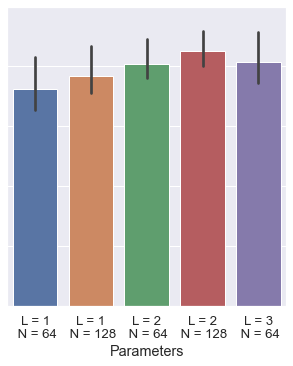

In [77]:
with paperStyle(12):
    sns.set(font_scale=1.2,rc={'figure.figsize':(5,5.5)})
    ax = sns.barplot(x="Parameters", y="SSIM",  data=dx1)
    ax.set_ylim(0,1)
    frame1 = plt.gca()
    frame1.axes.yaxis.set_ticklabels([])
    ax.set_ylabel('')
    #ax.axes.get_yaxis().set_visible(False)
plt.savefig('siren_hyp.svg', bbox_inches='tight')
plt.savefig('siren_hyp.pdf', bbox_inches='tight')

In [44]:
iqm =ImageQualityMetrics()
perc= normalize.PercentileNormalizer()
minmax=normalize.MinMaxNormalizer()
ppath = 'D:/jo77pihe/Registered/20220209_SIRENHypTun_z5'
data_path = 'D:/jo77pihe/Registered/20220203_AutoQuant_Averaged'
files = [f for f in os.listdir(ppath) if f.endswith('.tif')]
res = np.zeros((27,4))
for (i,f) in enumerate(files):
    parts=f.split('_')
    n_layers = int(parts[0])
    n_nodes = int(parts[1])
    res[i,0] = n_layers
    res[i,1] = n_nodes
    if n_nodes >64:
        name = f[6:]
    else:
        name=f[5:]
    pred = tif.imread(os.path.join(ppath,f))
    true = tif.imread(os.path.join(data_path,name))
    res[i,2]=iqm.ssim(perc.normalize(true[:5,:,:]), perc.normalize(pred), win_size=5)
    res[i,3]=iqm.ssim(minmax.normalize(true[:5,:,:]), minmax.normalize(pred), win_size=5)

In [56]:
res = res[res[:, 1].argsort()]  # sort by day
res = res[res[:, 0].argsort(kind='mergesort')] 

In [57]:
l = ['L = ' +str(int(res[l,0]))+'\n N = ' +str(int(res[l,1])) for l in range(res.shape[0])]

In [58]:
dx = pd.DataFrame({'Parameters':l, 'SSIM':res[:,2]})
pd.to_pickle(dx, 'siren_hyp_train_z5.pkl')

In [59]:
dx

,Parameters,SSIM
0,L = 1\n N = 64,0.897283
1,L = 1\n N = 64,0.724841
2,L = 1\n N = 64,0.665049
3,L = 1\n N = 128,0.917021
4,L = 1\n N = 128,0.750793
5,L = 1\n N = 128,0.773724
6,L = 1\n N = 256,0.802026
7,L = 1\n N = 256,0.808545
8,L = 1\n N = 256,0.945127
9,L = 2\n N = 64,0.833778


In [ ]:
dx= pd.read_pickle('siren_hyp_train_z5.pkl')

In [49]:
dx

,Parameters,SSIM
0,L = 1\n N = 128,0.917021
1,L = 1\n N = 128,0.773724
2,L = 1\n N = 128,0.750793
3,L = 1\n N = 256,0.945127
4,L = 1\n N = 256,0.808545
5,L = 1\n N = 256,0.802026
6,L = 1\n N = 64,0.897283
7,L = 1\n N = 64,0.724841
8,L = 1\n N = 64,0.665049
9,L = 2\n N = 128,0.952734


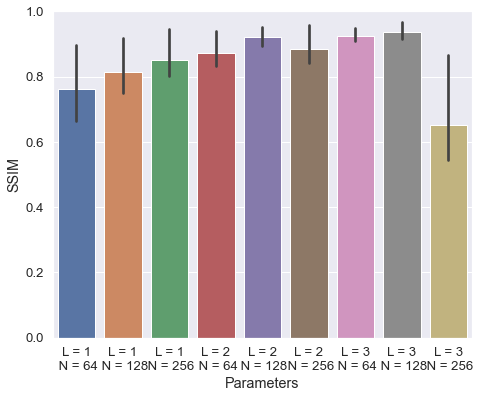

In [61]:
with paperStyle(12):
    sns.set(font_scale=1.2,rc={'figure.figsize':(7.5,6)})
    ax = sns.barplot(x="Parameters", y="SSIM",  data=dx)
    ax.set_ylim(0,1)
plt.savefig('siren_hyp_z5.svg', bbox_inches='tight')
plt.savefig('siren_hyp_z5.pdf', bbox_inches='tight')

## Visual inspection

Alessandro_520_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-08-31_A2.tif
0.0 16173.983
-0.060132775 0.78798693


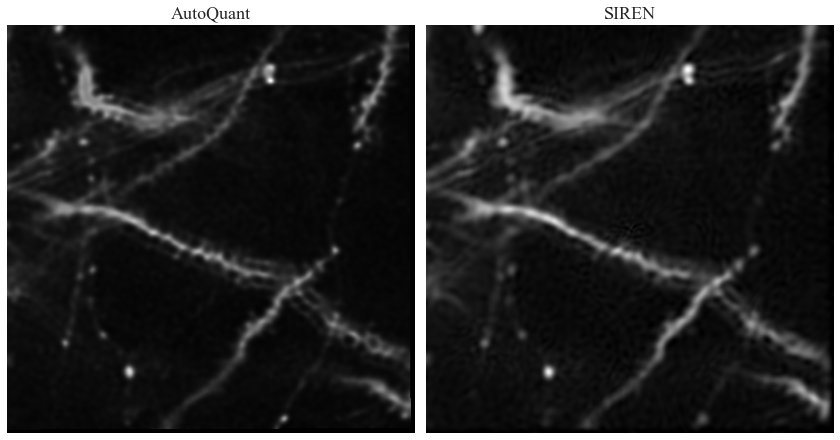

In [27]:
path = 'D:\\jo77pihe\\Registered\\20220209_SIRENHypTun'
path_gt = 'D:\\jo77pihe\\Registered\\20220203_AutoQuant_Averaged'

img1 = 'Alessandro_520_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-08-31_A2.tif'
plane = 8
prefix = '2_128_'
with paperStyle():
    mpl.rcParams['axes.titlesize'] = 18
    plt.rcParams['font.family'] = 'Times New Roman'
 
    print("\033[1m" + img1 + "\033[0m")
    fig=plt.figure()
    fig.set_figheight(7.5)
    fig.set_figwidth(15)

    n_h = 1
    n_w = 2
    #AQ
    f = tif.imread(os.path.join(path_gt, img1))
    ax = fig.add_subplot(n_h, n_w, 1)
    ax.imshow(f[plane, :, :],cmap='gray')#, <, vmax = 25000.996)
    ax.set_title('AutoQuant')
    ax.axis('off')
    print(f[plane, :, :].min(), f[plane, :, :].max())

    # SIREN
    f = tif.imread(os.path.join(path, prefix+img1))
    ax = fig.add_subplot(n_h, n_w, 2)
    ax.imshow(f[plane, :, :],cmap='gray', vmin=0.0)
    ax.set_title('SIREN')
    ax.axis('off')
    print(f[plane, :, :].min(), f[plane, :, :].max())


    plt.subplots_adjust(wspace=0.001, hspace=0.07)

plt.savefig('siren_visual_inspection.svg',bbox_inches='tight')
plt.savefig('siren_visual_inspection.pdf',bbox_inches='tight')

## Inter-Plane Prediction

In [14]:
res_path_int_p = 'D:/jo77pihe/Registered/20220224_SIRENInterplane'
data_path = 'D:/jo77pihe/Registered/20220203_AutoQuant_Averaged'
files = [f[2:] for f in os.listdir(res_path_int_p) if f.endswith('.tif')]
files_set = set(files)
files=list(files_set)
norm = normalize.PercentileNormalizer()
rescaler = normalize.Rescaler()

iqm = ImageQualityMetrics()

In [23]:
labs = []
res =[]
res_inner=[]
res_outer=[]
for f in files:
    stack_gt = np.asarray(tif.imread(os.path.join(data_path, f)), dtype=np.float32)[0:20, :, :]
    #xn =2 if f == 'Tim_25_NexCreERT2_2018-07-10_A7.tif' else 1
    print(f)
    for n in range(2,9):
        stack_pred=np.asarray(tif.imread(os.path.join(res_path_int_p, str(n)+'_'+f)), dtype=np.float32)
        # Filter planes used for training and testing
        mask = np.zeros(stack_gt.shape[0], dtype=bool)
        idx=np.arange(0,stack_gt.shape[0])[::n]
        mask[idx,] =True

        # subsample stack and grid
        stack_gt_f = stack_gt[~mask, :, :]
        stack_gt_f=norm.normalize(stack_gt_f)
        stack_pred=norm.normalize(stack_pred)
        #stack_pred = rescaler.normalize(stack_pred, np.min(stack_gt_f), np.max(stack_gt_f))

        labs.append(str(n))
        if stack_gt_f.shape[0]<7:
            win_size=stack_gt_f.shape[0]
            if win_size%2==0:
                win_size -=1
            res.append(iqm.ssim(stack_pred, stack_gt_f, win_size))
        else:
            res.append(iqm.ssim(stack_pred, stack_gt_f))
        
        ##### inner
        # midx=(stack_gt.shape[0]//n)*n -(len(idx))
# 
        # stack_gt_inner=stack_gt_f[:midx]
        # print(stack_gt_inner.shape)
        # stack_pred_inner=stack_pred[:stack_gt_inner.shape[0]]
        # #stack_pred = rescaler.normalize(stack_pred, np.min(stack_gt_f), np.max(stack_gt_f))
# 
        # if stack_gt_inner.shape[0]<7:
        #     win_size=stack_gt_inner.shape[0]
        #     if win_size%2==0:
        #         win_size -=1
        #     res_inner.append(iqm.ssim(stack_pred_inner, stack_gt_inner, win_size))
        # else:
        #     res_inner.append(iqm.ssim(stack_pred_inner, stack_gt_inner))
        

Tim_25_NexCreERT2_2018-07-10_A7.tif
Tim_178_ArcCre_2017-08-08_A2.tif
Ghabiba_347_Thy1GFP_2019-02-18_A5.tif
Tim_117_ArcCre_2017-05-08_A9.tif
Ghabiba_65_Thy1eGFP_2018-02-03_A1.tif


In [26]:
import pandas as pd
import seaborn as sns
d = {'Offset next training layer': labs, 'SSIM': res}#, 'SSIM_inner':res_inner}
df = pd.DataFrame(data=d)

In [27]:
df

,Offset next training layer,SSIM
0,2,0.871276
1,3,0.875749
2,4,0.762820
3,5,0.650846
4,6,0.798654
5,7,0.511005
6,8,0.596715
7,2,0.806552
8,3,0.704298
9,4,0.552976


In [28]:
pd.to_pickle(df,'siren_interplane_pred.pkl')

In [29]:
df = pd.read_pickle('siren_interplane_pred.pkl')

C:\Users\jo77pihe\.conda\envs\ma\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\jo77pihe\.conda\envs\ma\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


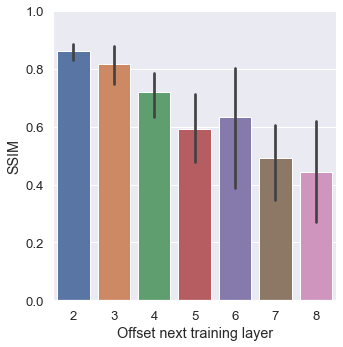

In [30]:
with paperStyle():
    #mpl.rcParams['axes.titlesize'] = 18
    #plt.rcParams['font.family'] = 'Times New Roman'
    sns.set(font_scale=1.2,rc={'figure.figsize':(4,5)})
    #sns.set(font_scale=1.1)
    g = sns.factorplot("Offset next training layer", "SSIM", data=df, kind="bar")
    plt.ylim(0, 1)
    #g.set_ylim([0,1])
plt.savefig('siren_interplane.svg',bbox_inches='tight')
plt.savefig('siren_interplane.pdf',bbox_inches='tight')

## Visual Inspection

Tim_178_ArcCre_2017-08-08_A2.tif
-0.0487467 0.36259508
-0.04658905 0.36502334
-0.06710947 0.34424338
-0.07660585 0.37527844


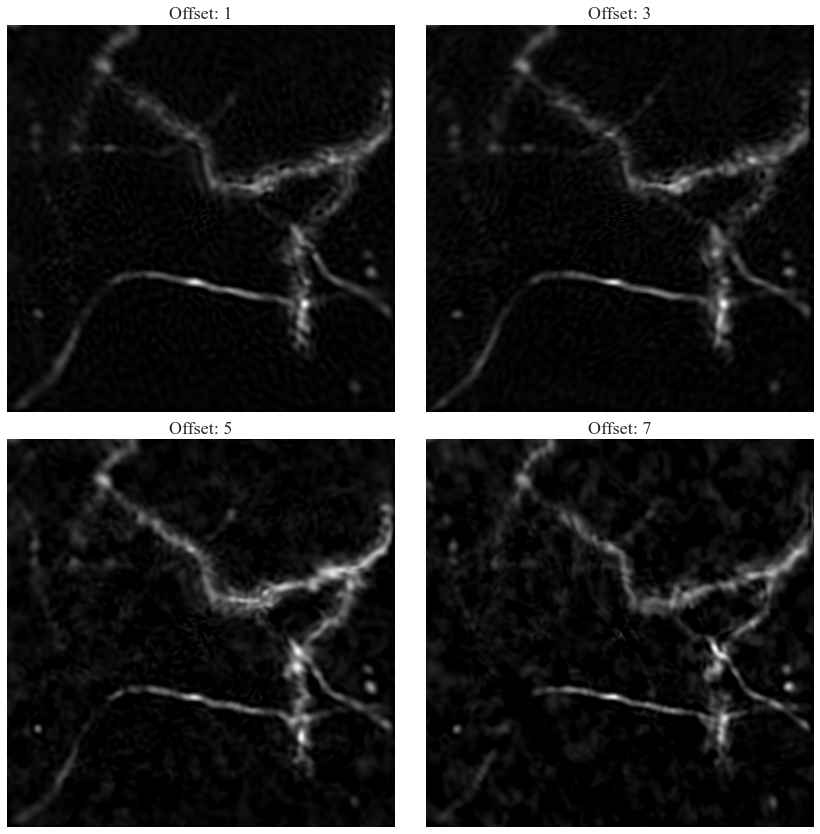

In [34]:
path1 = 'D:\\jo77pihe\\Registered\\20220209_SIRENHypTun'
path2 = 'D:\\jo77pihe\\Registered\\20220224_SIRENInterplane'

img1 = 'Tim_178_ArcCre_2017-08-08_A2.tif'

prefix='2_128_'
plane = 0
with paperStyle():
    mpl.rcParams['axes.titlesize'] = 18
    plt.rcParams['font.family'] = 'Times New Roman'
 
    print("\033[1m" + img1 + "\033[0m")
    fig=plt.figure()
    fig.set_figheight(30)
    fig.set_figwidth(15)

    n_h = 4
    n_w = 2
    
    
    #SIREN
    ix = 1
    for n in range(1,9,2):
        f = tif.imread(os.path.join(path2, str(n)+'_'+img1))
        ax = fig.add_subplot(n_h, n_w, ix)
        plane = 1 if n==1 else 0
        ax.imshow(f[plane, :, :],cmap='gray', vmin=0)#, <, vmax = 25000.996)
        ax.set_title('Offset: ' +str(n))
        ax.axis('off')
        print(f[plane, :, :].min(), f[plane, :, :].max())
        ix +=1


    plt.subplots_adjust(wspace=0.001, hspace=0.07)

plt.savefig('siren_int_visual_inspection.svg',bbox_inches='tight')
plt.savefig('siren_int_visual_inspection.pdf',bbox_inches='tight')

## Motion correction

In [2]:
from pystackreg import StackReg

In [49]:
rep_path='D:/jo77pihe/Registered/20220227_Repetitions_deconved'
res_path ='D:/jo77pihe/Registered/20220224_SIRENMotCorr'
files = [f for f in os.listdir(res_path) if f.endswith('.tif')]
normalizer = normalize.PercentileNormalizer()
iqm = ImageQualityMetrics()
res = []
for f in files:
    pred=tif.imread(os.path.join(res_path, f))
    print(np.min(pred), np.max(pred))
    
    filesx = [ft for ft in os.listdir(rep_path) if (os.path.isfile(os.path.join(rep_path, ft)) and (f[:-4] in ft))]
    
    avg_img = np.zeros(pred.shape)
    stackxy =np.zeros(pred.shape)
    for (i,fx) in enumerate(filesx):
        stack=tif.imread(os.path.join(rep_path, fx))[:5,:,:]
        if i >0:
            stack_x = np.zeros(stack.shape)
            for p in range(stack.shape[0]):
                sr = StackReg(StackReg.BILINEAR)
                stack_x[p,:,:] = sr.register_transform(prev_stack[p,:,:], stack[p,:,:])
            stack = stack_x.copy()
        else:
            prev_stack=stack.copy()
        avg_img +=normalizer.normalize(stack)
    avg_img /=len(filesx)
    tif.imwrite(os.path.join(rep_path, 'Averaged', f), avg_img)
    res.append(iqm.ssim(pred, avg_img, 5))

-0.04367422 1.3243724
-0.11947332 1.297317
-0.032827966 1.1353959
-0.05082681 1.366578
-0.034402654 1.2459948
-0.0364612 1.2042565
-0.052718863 1.4326228


In [44]:
tif.imwrite(os.path.join(rep_path, 'Averaged', f), avg_img)

In [45]:
f

'531Tim_25_NexCreERT2_2018-07-10_A4.tif'

In [39]:
res

[0.9863385773517186,
 0.9775561502464898,
 0.9641814483163496,
 0.981309594189453,
 0.9840470455448525,
 0.9797077273997241,
 0.9799778553000386]

In [40]:
np.mean(res)

0.9790169140498037

In [41]:
np.std(res)

0.006630997168873153

## Visual Inspection

531Tim_25_NexCreERT2_2018-07-10_A4
8.252446e-14 0.00013075545
8.11819e-08 0.00013969735
5.527681e-08 0.00013726455
5.891068e-08 0.00013660493


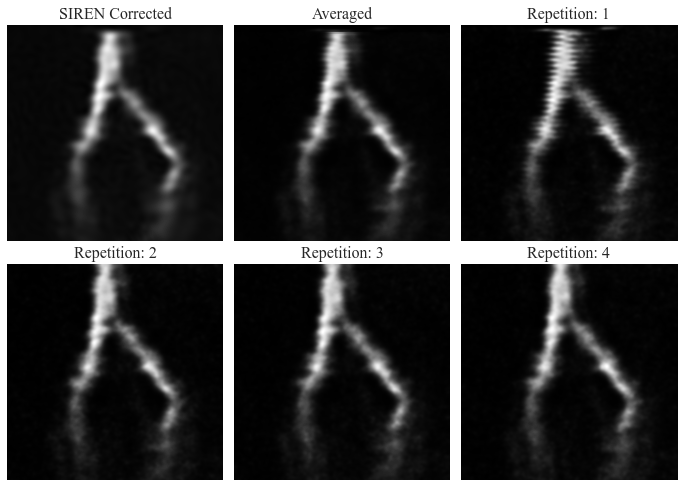

In [25]:
path1 = 'D:\\jo77pihe\\Registered\\20220227_Repetitions_deconved'
path2 = 'D:\\jo77pihe\\Registered\\20220224_SIRENMotCorr'

img1 = '531Tim_25_NexCreERT2_2018-07-10_A4'

appendix='.tif'
plane = 4
x_start = 100
y_start=0
width =250
with paperStyle():
    mpl.rcParams['axes.titlesize'] = 16
    plt.rcParams['font.family'] = 'Times New Roman'
 
    print("\033[1m" + img1 + "\033[0m")
    fig=plt.figure()
    fig.set_figheight(8.5)
    fig.set_figwidth(12)

    n_h = 2
    n_w = 3
    
    f = tif.imread(os.path.join(path2, img1+appendix))
    ax = fig.add_subplot(n_h, n_w, 1)
    ax.imshow(f[plane, y_start:(y_start+width), x_start:(x_start+width)],cmap='gray')
    ax.set_title('SIREN Corrected')
    ax.axis('off')
    
    f = tif.imread(os.path.join(path1+'/Averaged', img1+appendix))
    ax = fig.add_subplot(n_h, n_w, 2)
    ax.imshow(f[plane,y_start:(y_start+width), x_start:(x_start+width)],cmap='gray')
    ax.set_title('Averaged')
    ax.axis('off')
    
    
    #SIREN
    for n in range(1,5):
        f = tif.imread(os.path.join(path1, img1+str(n)+'.tif'))
        ax = fig.add_subplot(n_h, n_w, n+2)
        ax.imshow(f[plane, y_start:(y_start+width), x_start:(x_start+width)],cmap='gray')#, vmin=0)#, <, vmax = 25000.996)
        ax.set_title('Repetition: ' +str(n))
        ax.axis('off')
        print(f[plane, :, :].min(), f[plane, :, :].max())


    plt.subplots_adjust(wspace=0.05, hspace=0.07)

plt.savefig('siren_mot_visual_inspection.svg',bbox_inches='tight')
plt.savefig('siren_mot_visual_inspection.pdf',bbox_inches='tight')

In [3]:
rep_path='D:/jo77pihe/Registered/20220227_Repetitions_deconved'
res_path ='D:/jo77pihe/Registered/20220224_SIRENMotCorr'
files = [f for f in os.listdir(res_path) if ('531Tim_25_NexCreERT2_2018-07-10_A4' in f and f.endswith('.tif'))]
normalizer = normalize.PercentileNormalizer()
iqm = ImageQualityMetrics()
res = []
for f in files:
    pred=tif.imread(os.path.join(res_path, f))
    print(np.min(pred), np.max(pred))
    
    filesx = [ft for ft in os.listdir(rep_path) if (os.path.isfile(os.path.join(rep_path, ft)) and (f[:-4] in ft))]
    for (i,fx) in enumerate(filesx):
        stack=tif.imread(os.path.join(rep_path, fx))[:5,:,:]
        stack_x = np.zeros(stack.shape)
        for p in range(stack.shape[0]):
            sr = StackReg(StackReg.BILINEAR)
            stack_x[p,:,:] = sr.register_transform(pred[p,:,:], stack[p,:,:])
        stack = stack_x.copy()
        stack = normalizer.normalize(stack)
        res.append(iqm.ssim(pred, stack, 5))

-0.034402654 1.2459948


In [4]:
res_avg = []
for f in files:
    pred=tif.imread(os.path.join(rep_path,'Averaged', f))
    print(np.min(pred), np.max(pred))
    
    filesx = [ft for ft in os.listdir(rep_path) if (os.path.isfile(os.path.join(rep_path, ft)) and (f[:-4] in ft))]
    for (i,fx) in enumerate(filesx):
        stack=tif.imread(os.path.join(rep_path, fx))[:5,:,:]
        stack_x = np.zeros(stack.shape)
        for p in range(stack.shape[0]):
            sr = StackReg(StackReg.BILINEAR)
            stack_x[p,:,:] = sr.register_transform(pred[p,:,:], stack[p,:,:])
        stack = stack_x.copy()
        stack = normalizer.normalize(stack)
        res_avg.append(iqm.ssim(pred, stack, 5))

-5.716975647374056e-05 1.2658843696117401


C:\Users/jo77pihe/Documents/MasterThesis_OfSpinesAndDendrites\imagequalitymetrics.py:39: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  val = sk_ssim(img, gt_img, win_size=win_size)


In [5]:
res

[0.477623663399135, 0.8969624680776763, 0.8999114160784978, 0.8952381575966225]

In [6]:
res_avg

[0.4376453214227771,
 0.8867336021845484,
 0.8899566309000363,
 0.8847380735254369]

In [34]:
import pandas as pd
import seaborn as sns
rep = ['1', '2', '3', '4','1', '2', '3', '4']
labs = ['SIREN', 'SIREN', 'SIREN', 'SIREN','Averaged', 'Averaged', 'Averaged', 'Averaged']

res_x = res + res_avg
d = {'Repetition': rep, 'Algorithm': labs, 'SSIM': res_x}#, 'SSIM_inner':res_inner}
df = pd.DataFrame(data=d)

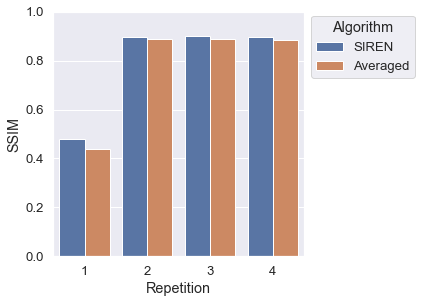

In [35]:
with paperStyle():
    fig=plt.figure()
    fig.set_figheight(4.5)
    fig.set_figwidth(4.5)
    sns.set(font_scale=1.2)
    g=sns.barplot(data=df, x="Repetition", y="SSIM", hue="Algorithm")
    g.legend(bbox_to_anchor=(1.0, 1.01),title='Algorithm')
    plt.ylim(0,1)
plt.savefig('siren_mot_sim_rep.svg',bbox_inches='tight')
plt.savefig('siren_mot_sim_rep.pdf',bbox_inches='tight')